### Import Lib

In [1]:
#!pip install spacy

In [2]:
import pandas as pd 
import numpy as np

from sklearn.preprocessing import LabelEncoder


import re
import nltk
from nltk.tokenize import ToktokTokenizer
nltk.download('stopwords')
nltk.download('wordnet')

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split 
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.pipeline import Pipeline 
from sklearn.preprocessing import MultiLabelBinarizer


## Metrics
from sklearn.metrics import accuracy_score,f1_score,average_precision_score,recall_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC,LinearSVC


import spacy
from bs4 import BeautifulSoup
import unicodedata
import string





import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
RANDOM_SEED = 39

### Load Data

In [4]:
data = pd.read_csv("blogtext.csv")

In [5]:
data.shape

(681284, 7)

In [6]:
#### Loading random 10000 rows for the analysis
data_new = data[:3000]
data_new.shape

(3000, 7)

### Exploratory Data Analysis

In [7]:
data_new.head()

,id,gender,age,topic,sign,date,text
0,2059027,male,15,Student,Leo,"14,May,2004","Info has been found (+/- 100 pages,..."
1,2059027,male,15,Student,Leo,"13,May,2004",These are the team members: Drewe...
2,2059027,male,15,Student,Leo,"12,May,2004",In het kader van kernfusie op aarde...
3,2059027,male,15,Student,Leo,"12,May,2004",testing!!! testing!!!
4,3581210,male,33,InvestmentBanking,Aquarius,"11,June,2004",Thanks to Yahoo!'s Toolbar I can ...


In [8]:
### Removing the id and data

data_new.drop(["id","date"],axis=1,inplace=True)
data_new.head()

,gender,age,topic,sign,text
0,male,15,Student,Leo,"Info has been found (+/- 100 pages,..."
1,male,15,Student,Leo,These are the team members: Drewe...
2,male,15,Student,Leo,In het kader van kernfusie op aarde...
3,male,15,Student,Leo,testing!!! testing!!!
4,male,33,InvestmentBanking,Aquarius,Thanks to Yahoo!'s Toolbar I can ...


In [9]:
print("Is any missing values",data_new.isna().sum().sum())

print("Shape of the data",data_new.shape)

Is any missing values 0
Shape of the data (3000, 5)


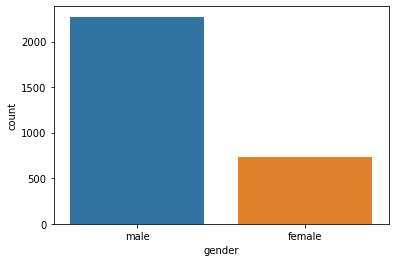

In [10]:
##### Distribution of gender
sns.countplot(data=data_new,x="gender") ### Distribution is equal

In [11]:
#### Unique Values for Age
print('Unique value')
#print(data.gender.unique())
#data_new.sort_values("age",inplace=True)
print(data_new.age.value_counts())

Unique value
35    1607
24     334
15     299
17     147
25     110
33      94
23      93
27      86
14      74
26      43
39      32
16      25
37      19
41      14
45      14
34       6
44       3
Name: age, dtype: int64


In [12]:
### distribution for topic
data_new["topic"].value_counts() ### distribution is implanced 

Technology              1607
indUnk                   452
Student                  403
Engineering              119
Education                118
Sports-Recreation         75
InvestmentBanking         70
Non-Profit                46
Science                   33
BusinessServices          21
Internet                  20
Banking                   16
Communications-Media      14
Accounting                 2
Museums-Libraries          2
Arts                       2
Name: topic, dtype: int64

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text major ticklabel objects>)

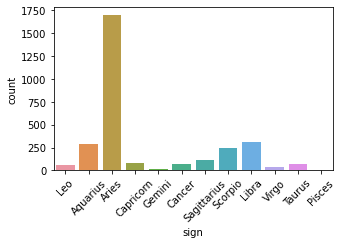

In [13]:
### Distibution of sign 
plt.subplots(figsize=(5,3))
sns.countplot(data=data_new,x="sign") # No major difference in the count for each category
plt.xticks(rotation=45)

In [14]:
### Merge the labels
#print(data_new.columns)
data_new['age'] = data_new['age'].astype(str)
data_new["target"] = data_new[["gender","age","topic","sign"]].apply(lambda x:",".join(x),axis= 1)
data_new.drop(['gender', 'age', 'topic', 'sign'],inplace = True,axis=1)
data_new.head()

,text,target
0,"Info has been found (+/- 100 pages,...","male,15,Student,Leo"
1,These are the team members: Drewe...,"male,15,Student,Leo"
2,In het kader van kernfusie op aarde...,"male,15,Student,Leo"
3,testing!!! testing!!!,"male,15,Student,Leo"
4,Thanks to Yahoo!'s Toolbar I can ...,"male,33,InvestmentBanking,Aquarius"


In [15]:
#### Text Processing

tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')
stemmer = nltk.porter.PorterStemmer()
lem = nltk.stem.wordnet.WordNetLemmatizer()




def remove_html_tags(text):
    return BeautifulSoup(text, 'html.parser').get_text()

def remove_accented_chars(text):
    new_text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return new_text

def remove_special_characters(text):
    # define the pattern to keep
    pat = r'[^a-zA-z0-9.,!?/:;\"\'\s]' 
    return re.sub(pat, '', text)

def remove_numbers(text):
    # define the pattern to keep
    pattern = r'[^a-zA-z.,!?/:;\"\'\s]' 
    return re.sub(pattern, '', text)

def remove_punctuation(text):
    text = ''.join([c for c in text if c not in string.punctuation])
    return text

def remove_extra_whitespace_tabs(text):
    pattern = r'^\s*|\s\s*'
    return re.sub(pattern, ' ', text).strip()

def to_lowercase(text):
    return text.lower()


def remove_stopwords(text):
    # convert sentence into token of words
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    # check in lowercase 
    t = [token for token in tokens if token.lower() not in stopword_list]
    text = ' '.join(t)    
    return text

def get_stem(text):
    stemmer = nltk.porter.PorterStemmer()
    text = ' '.join([stemmer.stem(word) for word in text.split()])
    return text

def get_lem(text):
    text = ' '.join([lem.lemmatize(word) for word in text.split()])
    return text


# re.sub(r'[^a-zA-z.,!?/:;\"\'\s]', '', str(data_new["text"].head(5)))

In [16]:
def text_processing(text):
    text = to_lowercase(text)
    text = remove_html_tags(text)
    text = remove_accented_chars(text)
    text = remove_special_characters(text)
    text = remove_numbers(text)
    text = remove_punctuation(text)
    text = remove_extra_whitespace_tabs(text)
    text = get_stem(text)
    text = get_lem(text)
    text = remove_stopwords(text)
    return text
    
data_new["text"] = data_new["text"].apply(text_processing)    
data_new.head()        

,text,target
0,info ha found page mb pdf file wait team leade...,"male,15,Student,Leo"
1,team member drew van der laag urllink mail rui...,"male,15,Student,Leo"
2,het kader van kernfusi op aard maak je eigen w...,"male,15,Student,Leo"
3,test test,"male,15,Student,Leo"
4,thank yahoo toolbar captur url popupswhich mea...,"male,33,InvestmentBanking,Aquarius"


In [17]:
print(data_new.isna().sum())### Check is there any missing value after processing
data_new.dropna(inplace=True)
print(data_new.isna().sum())

text      0
target    0
dtype: int64
text      0
target    0
dtype: int64


In [18]:
### Convert target to lower case
data_new["target"] = data_new["target"].apply(to_lowercase)    
data_new["target"] = data_new["target"].apply(remove_special_characters) 
data_new["target"] = data_new["target"].apply(remove_extra_whitespace_tabs) 

data_new.head()        

,text,target
0,info ha found page mb pdf file wait team leade...,"male,15,student,leo"
1,team member drew van der laag urllink mail rui...,"male,15,student,leo"
2,het kader van kernfusi op aard maak je eigen w...,"male,15,student,leo"
3,test test,"male,15,student,leo"
4,thank yahoo toolbar captur url popupswhich mea...,"male,33,investmentbanking,aquarius"


### Test Train split

In [19]:
X = data_new['text']
y = data_new["target"]
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = RANDOM_SEED)

print("X_train Shape",X_train.shape)
print("y_train Shape",y_train.shape)

print("X_test Shape",X_test.shape)
print("y_test Shape",y_test.shape)

X_train Shape (2400,)
y_train Shape (2400,)
X_test Shape (600,)
y_test Shape (600,)


### Encoding target value

In [20]:
vectorizer_labels = CountVectorizer(min_df = 1,ngram_range = (1,1),stop_words = "english")
labels_vector = vectorizer_labels.fit_transform(y)
label_classes=[]
for  key in vectorizer_labels.vocabulary_.keys():
  label_classes.append(key)
print("unique labels ",label_classes)

unique labels  ['male', '15', 'student', 'leo', '33', 'investmentbanking', 'aquarius', 'female', '14', 'indunk', 'aries', '25', 'capricorn', '17', 'gemini', '23', 'nonprofit', 'cancer', 'banking', '37', 'sagittarius', '26', '24', 'scorpio', '27', 'education', '45', 'engineering', 'libra', 'science', '34', '41', 'communicationsmedia', 'businessservices', 'sportsrecreation', 'virgo', 'taurus', 'arts', 'pisces', '44', '16', 'internet', 'museumslibraries', 'accounting', '39', '35', 'technology']


In [21]:
mlp = MultiLabelBinarizer(classes = label_classes)
y  = [s.split(",") for s in y]
mlp.fit(y)

MultiLabelBinarizer(classes=['male', '15', 'student', 'leo', '33',
                             'investmentbanking', 'aquarius', 'female', '14',
                             'indunk', 'aries', '25', 'capricorn', '17',
                             'gemini', '23', 'nonprofit', 'cancer', 'banking',
                             '37', 'sagittarius', '26', '24', 'scorpio', '27',
                             'education', '45', 'engineering', 'libra',
                             'science', ...])

In [22]:
y_train = [s.split(",") for s in y_train]
y_train = mlp.transform(y_train)

y_test = [s.split(",") for s in y_test]
y_test = mlp.transform(y_test)

### Approach 1 - Using BoW

In [23]:
def metrics(true,predict):
    print('Test Accuracy score: ', accuracy_score(true,predict))
    print('F1 score: weighted', f1_score(true,predict, average='weighted'))
    print('Average precision score: weighted', average_precision_score(true,predict, average='weighted'))
    print('Average recall score: weighted', recall_score(true,predict, average='weighted'))

In [24]:
bow_vector = CountVectorizer(min_df = 2,ngram_range = (1,2),stop_words = "english")

In [25]:
####  LogisticRegression
lg = LogisticRegression(solver='sag')

## pipeline
bow_lg_pipeline = Pipeline([("vectorizer", bow_vector),  
                      ("classifier", OneVsRestClassifier(lg))])

bow_lg_pipeline.fit(X_train,y_train)

print("Train accuracy - ", bow_lg_pipeline.score(X_train,y_train))
y_predict = bow_lg_pipeline.predict(X_test)

print("-------Score for Linear regression- OneVsRestClassifier with BoW ------")
metrics(y_test,y_predict)

Train accuracy -  0.4775
-------Score for Linear regression- OneVsRestClassifier with BoW ------
Test Accuracy score:  0.31166666666666665
F1 score: weighted 0.6101977576802216
Average precision score: weighted 0.5746338119575795
Average recall score: weighted 0.5441666666666667


In [26]:
#### MultinomialNB
mNB = MultinomialNB(fit_prior=True, class_prior=None)

## pipeline
bow_NB_pipeline = Pipeline([("vectorizer", bow_vector),  
                      ("classifier", OneVsRestClassifier(mNB))])

bow_NB_pipeline.fit(X_train,y_train)

print("Train accuracy - ", bow_NB_pipeline.score(X_train,y_train))
y_predict = bow_NB_pipeline.predict(X_test)
print("-------Score for MultinomialNB - OneVsRestClassifier with BoW ------")
metrics(y_test,y_predict)

Train accuracy -  0.7441666666666666
-------Score for MultinomialNB - OneVsRestClassifier with BoW ------
Test Accuracy score:  0.4033333333333333
F1 score: weighted 0.6720436465185925
Average precision score: weighted 0.6474300863194618
Average recall score: weighted 0.5816666666666667


In [27]:
#### LinearSVC
svc = LinearSVC()

## pipeline
bow_svc_pipeline = Pipeline([("vectorizer", bow_vector),  
                      ("classifier", OneVsRestClassifier(svc))])

bow_svc_pipeline.fit(X_train,y_train)

print("Train accuracy - ", bow_svc_pipeline.score(X_train,y_train))
y_predict = bow_svc_pipeline.predict(X_test)
print("-------Score for LinearSVC - OneVsRestClassifier with BoW ------")
metrics(y_test,y_predict)

Train accuracy -  0.99875
-------Score for LinearSVC - OneVsRestClassifier with BoW ------
Test Accuracy score:  0.5716666666666667
F1 score: weighted 0.7330110982080398
Average precision score: weighted 0.6355561724766374
Average recall score: weighted 0.7316666666666667


### Approach 2 -  Tf-Idf

In [28]:
tfidf_vector = TfidfVectorizer()

In [29]:
####  LogisticRegression
lg = LogisticRegression(solver='sag')

## pipeline
tfidf_lg_pipeline = Pipeline([("vectorizer", tfidf_vector),  
                      ("classifier", OneVsRestClassifier(lg))])

tfidf_lg_pipeline.fit(X_train,y_train)

print("Train accuracy - ", tfidf_lg_pipeline.score(X_train,y_train))
y_predict = tfidf_lg_pipeline.predict(X_test)

print("-------Score for Linear regression- OneVsRestClassifier with TfidfVectorizer ------")
metrics(y_test,y_predict)


Train accuracy -  0.54125
-------Score for Linear regression- OneVsRestClassifier with TfidfVectorizer ------
Test Accuracy score:  0.48333333333333334
F1 score: weighted 0.5830748505909418
Average precision score: weighted 0.5544726995742807
Average recall score: weighted 0.5879166666666666


In [30]:
#### MultinomialNB
mNB = MultinomialNB(fit_prior=True, class_prior=None)

## pipeline
tfidf_NB_pipeline = Pipeline([("vectorizer", tfidf_vector),  
                      ("classifier", OneVsRestClassifier(mNB))])

tfidf_NB_pipeline.fit(X_train,y_train)

print("Train accuracy - ", tfidf_NB_pipeline.score(X_train,y_train))
y_predict = tfidf_NB_pipeline.predict(X_test)
print("-------Score for MultinomialNB- OneVsRestClassifier with TfidfVectorizer ------")
metrics(y_test,y_predict)

Train accuracy -  0.4195833333333333
-------Score for MultinomialNB- OneVsRestClassifier with TfidfVectorizer ------
Test Accuracy score:  0.275
F1 score: weighted 0.44913484595119285
Average precision score: weighted 0.5009724788503029
Average recall score: weighted 0.4166666666666667


In [31]:
#### LinearSVC
svc = LinearSVC()

## pipeline
tfidf_svc_pipeline = Pipeline([("vectorizer", tfidf_vector),  
                      ("classifier", OneVsRestClassifier(svc))])

tfidf_svc_pipeline.fit(X_train,y_train)

print("Train accuracy - ", tfidf_svc_pipeline.score(X_train,y_train))
y_predict = tfidf_svc_pipeline.predict(X_test)
print("-------Score for LinearSVC - OneVsRestClassifier with TfidfVectorizer ------")
metrics(y_test,y_predict)

Train accuracy -  0.9941666666666666
-------Score for LinearSVC - OneVsRestClassifier with TfidfVectorizer ------
Test Accuracy score:  0.5983333333333334
F1 score: weighted 0.7554008613564006
Average precision score: weighted 0.6884179034977158
Average recall score: weighted 0.72125


 - Linear regression - OneVsRestClassifier with TfidfVectorizer has better score with overfit
 - Train accuracy - 54 % / Test accuracy - 48 %


In [32]:
### True vs predicted value for 

y_predict = tfidf_lg_pipeline.predict(X_test)

In [33]:
for index in [5,10,16,17,18]:    
    print("Predicted Value", mlp.inverse_transform(y_predict)[index])
    print("Original value ", mlp.inverse_transform(y_test)[index])
    print("----------------")

Predicted Value ('male', 'aries', '35', 'technology')
Original value  ('male', 'aries', '35', 'technology')
----------------
Predicted Value ('male', 'aries', '35', 'technology')
Original value  ('male', 'aries', '35', 'technology')
----------------
Predicted Value ('female',)
Original value  ('female', 'indunk', 'taurus', '16')
----------------
Predicted Value ('male', 'aries', '35', 'technology')
Original value  ('male', 'aries', '35', 'technology')
----------------
Predicted Value ('male', 'aries', '35', 'technology')
Original value  ('male', 'aries', '35', 'technology')
----------------
